<a href="https://colab.research.google.com/github/gtoubian/cce/blob/main/3_3_PCA_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Principal Component Analysis

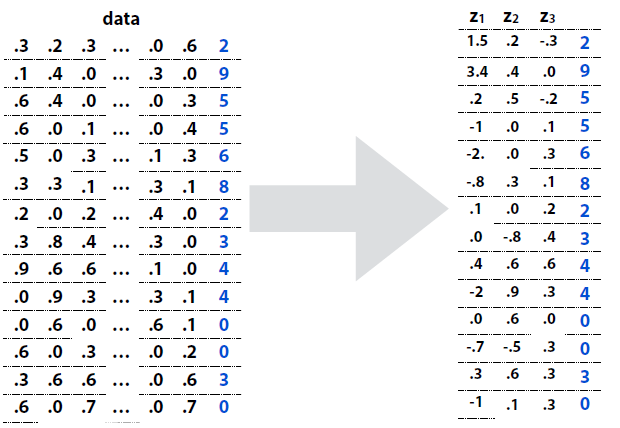

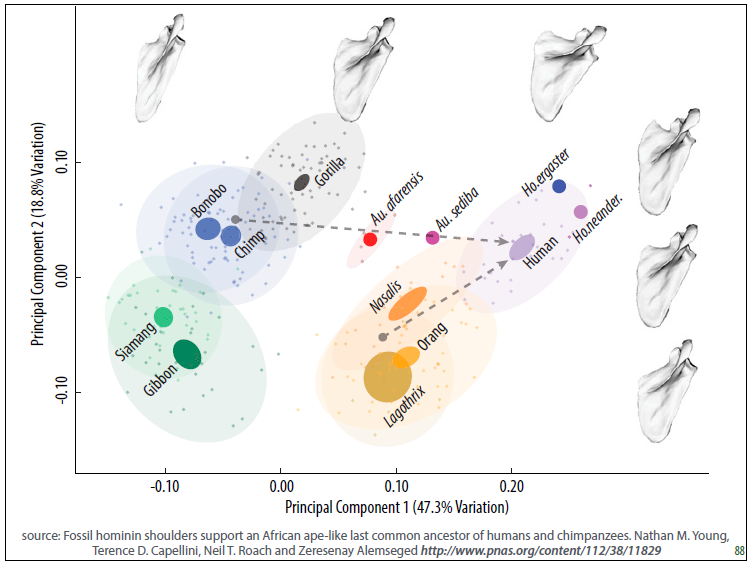

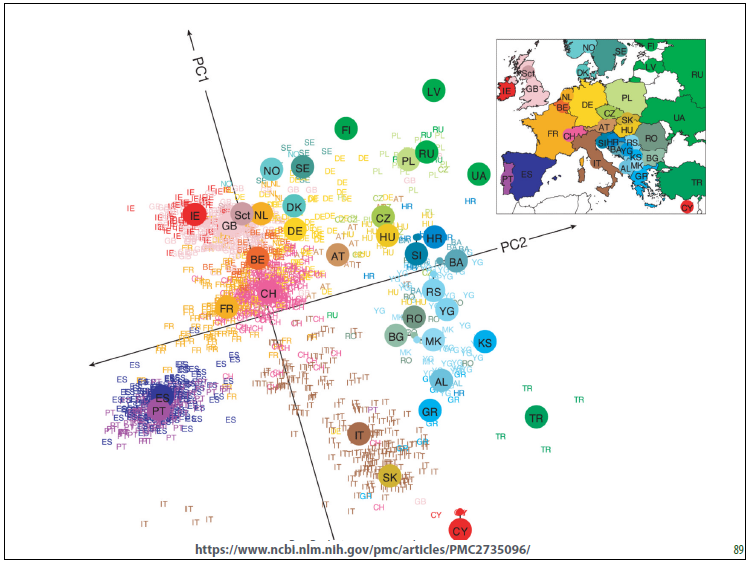

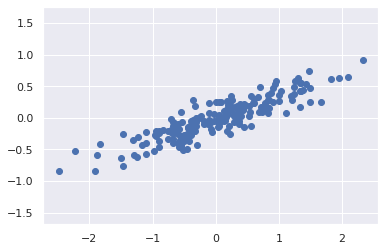

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables.


This is well fit by linear regression, but the problem setting here is slightly different: we want to **decompose** the relationship in an **unsupervised learning** manner rather than using $y$ as supervised learning labels.

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [2]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [3]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [4]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

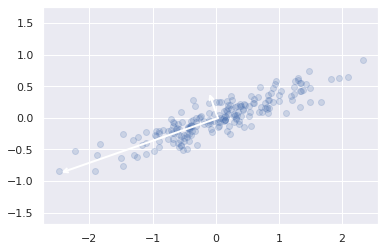

In [5]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" (in terms of explained variance) that axis is in describing the distribution of the data.

The projection of each data point onto the principal axes are the "principal components" of the data.

Necessarily, each other principal component is uncorrelated to  each other, so they're orthogonal (at 90 degrees).

Sidenote: PCA is found by eigendecomposition of the covariance matrix of the data. The implementation is actually quite short:

In [6]:
def pca(X):
    # Data matrix X, assumes 0-centered
    n, m = X.shape
    assert np.allclose(X.mean(axis=0), np.zeros(m))
    # Compute covariance matrix
    C = np.dot(X.T, X) / (n-1)
    # Eigen decomposition
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    # Project X onto PC space
    X_pca = np.dot(X, eigen_vecs)
    return X_pca

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

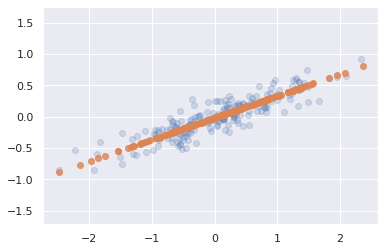

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

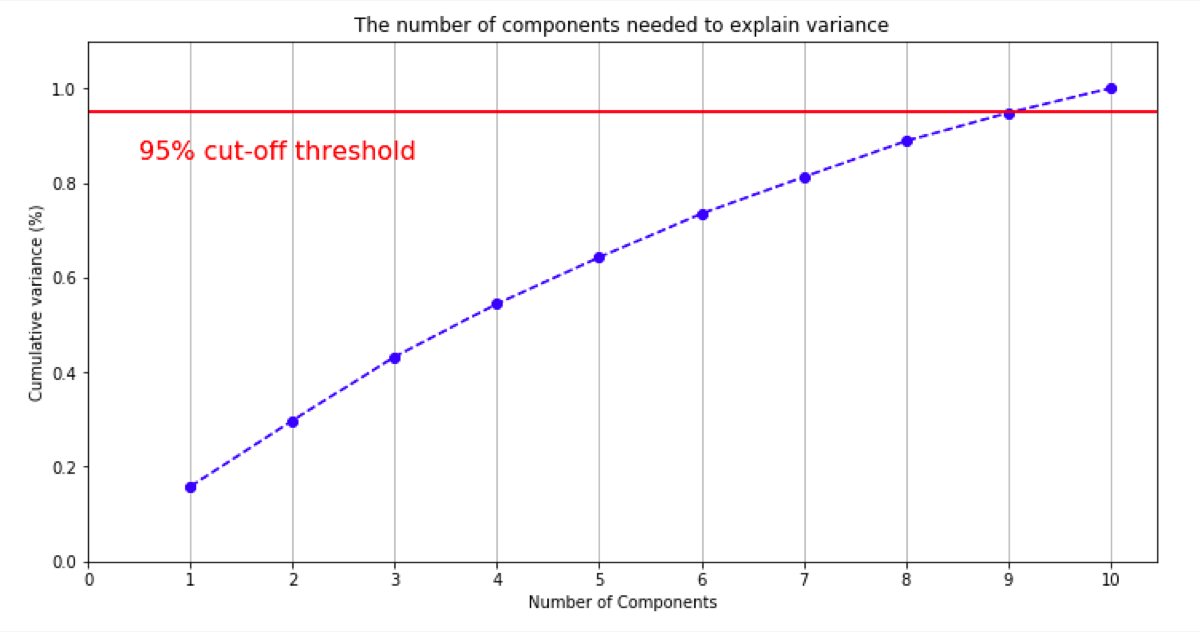